In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy

In [2]:
class TestGLM(nn.Module):
    def __init__(self, C_syn, T_no, sub_no, in_no, device):
        super().__init__()
        
        self.T_no = T_no
        self.in_no = in_no
        self.device = device
        self.C_syn = C_syn
        self.sub_no = sub_no
        
        self.spike = nn.Parameter(torch.ones(self.in_no), requires_grad=True)
        self.kern = nn.Parameter(torch.ones(self.sub_no, self.T_no)*0.01, requires_grad=True)
        self.hist = nn.Parameter(torch.ones(self.sub_no, self.T_no)*0, requires_grad=True)
        self.theta = nn.Parameter(torch.ones(self.sub_no)*0, requires_grad=True)
        self.scale = nn.Parameter(torch.ones(self.sub_no)*1, requires_grad=True)
        self.bias = nn.Parameter(torch.ones(1)*0, requires_grad=True)
        
    def forward(self, S):
        T_data = S.shape[0]
        
        S = S * self.spike.reshape(1,-1)
        S = torch.matmul(S, self.C_syn.T)
        S_pad = torch.zeros(T_data + self.T_no-1, self.sub_no).to(self.device)
        S_pad[-T_data:] = S_pad[-T_data:] + S
        
        kern = torch.flip(self.kern, [1]).unsqueeze(1)
        S_conv = F.conv1d(S_pad.T.unsqueeze(0), kern, groups=self.sub_no).squeeze(0).T
        
        sub_out = torch.zeros(T_data + self.T_no, self.sub_no).to(self.device)
        
        for t in range(T_data):
            out_hist = sub_out[t:t+self.T_no].clone()
            hist_in = torch.sum(out_hist.T * torch.flip(self.hist, [1]) ,1)
            t_out = torch.tanh(S_conv[t] + hist_in + self.theta)
            sub_out[t+self.T_no] = sub_out[t+self.T_no] + t_out
            
        final = torch.matmul(sub_out[self.T_no:], self.scale).flatten() + self.bias
        return final

In [3]:
base_dir = "/media/hdd01/sklee/"
experiment = "clust4-60"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
device = "cuda"

E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)

#V = np.load("/media/hdd01/sklee/CA1_clust4-60/gru_s4_h4_nospat_subout.npy")
V = np.load("/media/hdd01/sklee/CA1_clust4-60/data/V_diff.npy")

V = torch.from_numpy(V)

In [4]:
in_no = 299
T_no = 500
sub_no = 4
device = torch.device("cuda")
#sub = 1
batch_size = 50000

epoch_no = 5

C_syn = torch.zeros(sub_no, in_no).to(device)
for i in range(in_no):
    idx = e_idx[i]
    if eloc[idx,0] == den_idx[0]:
        C_syn[0,i] = 1
    elif eloc[idx,0] == den_idx[1]:
        C_syn[1,i] = 1
    elif eloc[idx,0] == den_idx[2]:
        C_syn[2,i] = 1
    elif eloc[idx,0] == den_idx[3]:
        C_syn[3,i] = 1

In [5]:
V_test = V[999*50000:1000*50000].float()
V_train = V[:999*50000].to(device).float()

test_E_neural = E_neural[999*50000:1000*50000].toarray()
train_E_neural = E_neural[:999*50000]
test_E_neural = torch.from_numpy(test_E_neural).float().to(device)

iter_no = epoch_no*999*50000//batch_size
train_idx = np.empty((epoch_no, 999*50000//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0,999*50000,batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [6]:
model = TestGLM(C_syn, T_no, sub_no, in_no, device)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

4308


In [7]:
for i in tnrange(iter_no):
    model.train()
    optimizer.zero_grad()
    
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx:batch_idx+batch_size].toarray()
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_V = V_train[batch_idx:batch_idx+batch_size].to(device)
    
    V_pred = model(batch_E_neural[:,e_idx])
    
    train_score = explained_variance_score(batch_V.cpu().detach().numpy(), V_pred.cpu().detach().numpy())
            
    loss = torch.var(V_pred - batch_V)
    #loss = torch.mean((V_pred - batch_V)**2)
    loss.backward()
    optimizer.step()
    
    #train_score = explained_variance_score(batch_V.cpu().detach().numpy(), V_pred.cpu().detach().numpy())
    #print(np.round(train_score,6))
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred = model(test_E_neural[:,e_idx])
        test_score = explained_variance_score(V_test.cpu().detach().numpy(), test_V_pred.cpu().detach().numpy())
        
        print("TEST", i, np.round(test_score,6),
              np.round(train_score,6))


<ipython-input-7-7ed9e0a9b246>:1: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


TEST 0 -0.066753 -0.756958
TEST 49 0.221099 0.281199
TEST 99 0.23795 0.29209
TEST 149 0.231604 0.284404
TEST 199 0.247805 0.317446
TEST 249 0.243678 0.275712
TEST 299 0.250607 0.289045
TEST 349 0.231159 0.264081
TEST 399 0.233934 0.366542
TEST 449 0.242515 0.271732
TEST 499 0.243046 0.268521
TEST 549 0.244012 0.286277
TEST 599 0.243437 0.26601
TEST 649 0.214102 0.235927
TEST 699 0.244846 0.285464
TEST 749 0.23087 0.259767
TEST 799 0.237621 0.349881
TEST 849 0.24971 0.310466



KeyboardInterrupt: 

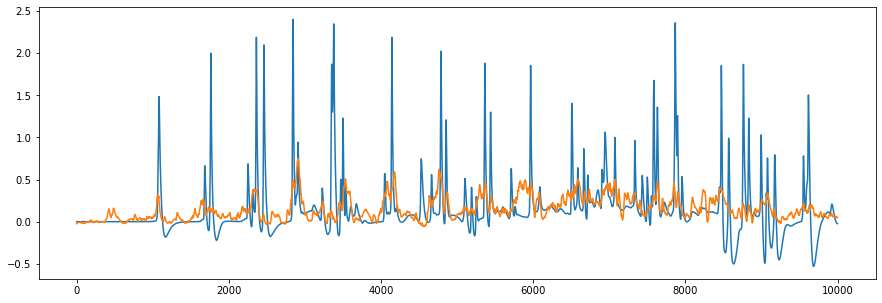

In [11]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[16000:26000])
plt.plot(test_V_pred.cpu().detach().numpy()[16000:26000])

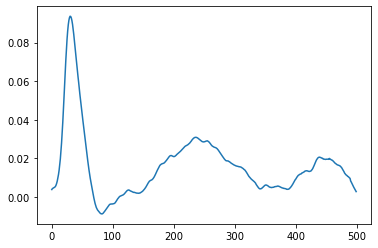

In [9]:
plt.plot(model.kern[1].cpu().detach().numpy())

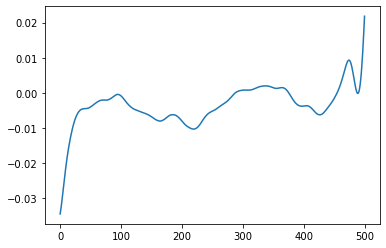

In [10]:
plt.plot(model.hist[1].cpu().detach().numpy())

In [ ]:
plt.plot(model.spike.cpu().detach().numpy())